# Step 1: Open the data file and study the general information

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
from functools import reduce
import math
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('games.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


With a quick glance at our data, let's determine what we can change. 

* replace column names, and convert them to lowercase characters.
* The **Name** column has 2 missing values - we can't determine the game without the name, so we'll remove these two rows.
* The **Year of Release** column has floats, we can change these to integers since we can't have fraction of a year. Alternatively we can change it to a datetime object. Additionally, there are about 270 missing values from this column. We don't need to know these values as it won't significantly impact our dataset, but in the future we can scrape the year of release data from some other source if we want to fill it in. Or we could fill it in manually. 
* **Genre** has two missing values. We can assume the user didn't know what to classify it as, so we'll fill it with 'Misc'.
* **Critic score** seems to have a lot of missing values, but we'll ignore it since we don't need this. We'll determine how user score affect sales for a popular platform.
* **User score** needs to be converted to a float. It also has a lot of missing values so we'll fill it with a mean as well.
* **Rating** has a lot of missing values. Based on our initial observation, we'll assume NaN actually means E for everyone.

After preprocessing the data, we'll create a new column with the total sales for each game.

# Step 2: Prepare the data

In [4]:
#lowercase column names
data.columns = map(str.lower, data.columns)

#remove rows with missing names. This also removes the rows with missing genres, so we killed 2 birds with 1 stone.
data = data[data.name.notnull()]

#convert to int
data['year_of_release'] = data['year_of_release'].astype('Int64')

#convert to float, coerce argument is necessary since we're getting strange strings for some values. Then we fill null values with the mean.
data['user_score'] = data['user_score'].apply(pd.to_numeric, errors='coerce')
data['user_score'] = data['user_score'].fillna(data['user_score'].mean())
#convert null values to E for everyone
data['rating']= data['rating'].fillna('E')

#create total sales column
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']

#perfect.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
 11  total_sales      16713 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


Now that we completed preprocessing the data, we can now analyze it.

# Step 3: Analyze the data

## Games released per year

Game release date mean:  2006.4862563853078 
Game release date median:  2007.0


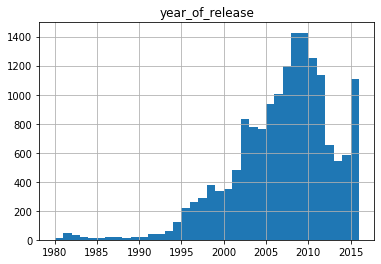

In [5]:
#in hindsight I didn't need to do this, but we'll keep it anyways
#group by year, and count games for each year
# year_grouped = data.groupby('year_of_release').size().reset_index(name="count")

#plot histogram to see number of games release per year
data.hist('year_of_release', bins = 36)
print('Game release date mean: ', data['year_of_release'].mean(), '\nGame release date median: ', data['year_of_release'].median())

We can see that the number of games released exponentially increased between 1980 and 2012, but dropped afterwards. The data has a left skew, with a median release date in 2007.

## Platform sales duration

In [6]:
# group by platforms, count, and find top 2 platforms by sorting in descending order
platforms_grouped = data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales',ascending=False)
# here we see that PS console rank high in total sales. We'll use the PS2 and PS3 consoles to determine the information we need.
platforms_grouped.head()

,total_sales
platform,
PS2,1062.33
X360,885.66
Wii,828.44
PS3,803.97
DS,746.86


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021D64DD8AC8>]],
      dtype=object)

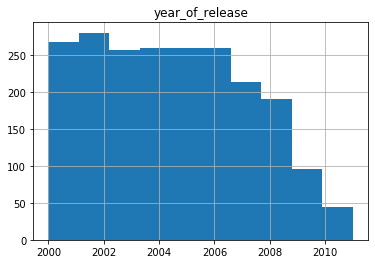

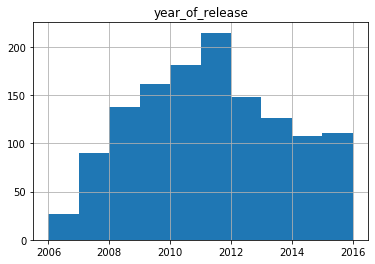

In [7]:
ps2_data = data.query('platform == "PS2"')
ps3_data = data.query('platform == "PS3"')

ps2_data.hist('year_of_release')
ps3_data.hist('year_of_release')


As we can see from the histograms, the PS2 console stayed relevant for approximately **10 years** before finally phasing out. If we look closely, we can notice a similarity between the two plots - it took approximately **4 years** between the years of **2006-2010** for the next generation console (PS3) to entirely replace the previous generation's console (PS2). Games released for the PS2 slowly decreased, and games released for the PS3 slowly increased.

Our end goal is to determine patterns that determine whether a game succeeds or not. **If we're trying to determine these patterns to maximize potential profits for releasing a game in 2017, we should base our data from the previous year, as trending game types and consoles change over the course of time, and data from 2016 will give us the most relevant information.**

## 2016 data

In [8]:
#here we have to filter the null values to prevent errors, and check the year of release.
recent_data = data[(~data['year_of_release'].isnull()) & (data['year_of_release']==2016)]
recent_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.000000,E,6.49
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,7.125046,E,6.69
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.900000,T,4.54
245,Call of Duty: Infinite Warfare,PS4,2016,Shooter,1.61,2.00,0.15,0.71,77.0,3.400000,M,3.76
289,Battlefield 1,PS4,2016,Shooter,1.10,2.15,0.21,0.61,88.0,8.400000,M,3.46


Now we can analyze this data subset.

## Platforms leading in sales, 2016

In [9]:
recent_grouped = recent_data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales',ascending=False)

recent_grouped.head()

,total_sales
platform,
PS4,59.01
XOne,23.91
3DS,14.50
PC,4.89
WiiU,4.25


The PS4 has immensely higher sales than any other platform in 2016. We'll see if the platform is continuing to trend, or if it's declining. If it's inclining, it's safe to say that the PS4 is the best platform to release a new game for in 2017.

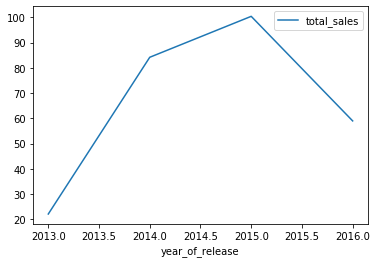

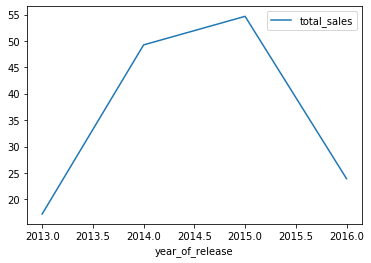

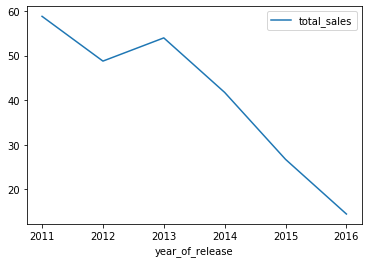

In [81]:
#we'll compare several platforms for the sake of it
ps4_trend = data[data['platform']=='PS4'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()
xone_trend = data[data['platform']=='XOne'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()
ds_trend = data[data['platform']=='3DS'].groupby('year_of_release').agg({'total_sales':'sum'}).reset_index()
ps4_trend.plot(x='year_of_release',y='total_sales')
xone_trend.plot(x='year_of_release',y='total_sales')
ds_trend.plot(x='year_of_release',y='total_sales')

Our graph shows a dip in sales in 2016, but judging by the fact that the other most popular platforms declined in sales as well, there may have been an external factor contributing to the decline in sales, such as a decrease in popularity of gaming in general, or a lack of good games released on all the popular consoles. Nevertheless, the PS4 console still made the highest total profit, and at least its graph doesn't look like the 3DS' graph. We'll choose the PS4 as our platform of choice.

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc86227d88>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc8618f088>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc86182808>,
 'medians': [<matplotlib.lines.Line2D at 0x1bc8617d448>,
 'fliers': [<matplotlib.lines.Line2D at 0x1bc8622dbc8>,
 'means': []}

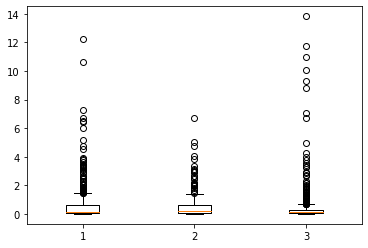

In [84]:
#this works too, just going to leave this here for future reference
#recent_data[['platform','total_sales']].boxplot(by='platform', column='total_sales')

ps4_data = data.query('platform == "PS4"')
xone_data = data.query('platform == "XOne"')
ds_data = data.query('platform == "3DS"')

plt.boxplot([ps4_data['total_sales'], xone_data['total_sales'], ds_data['total_sales']])

it's a bit hard to determine much from this graph so we'll display these without the outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x1bc86152b08>,
 'caps': [<matplotlib.lines.Line2D at 0x1bc86152708>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bc86100d48>,
 'medians': [<matplotlib.lines.Line2D at 0x1bc861f0dc8>,
 'fliers': [],
 'means': []}

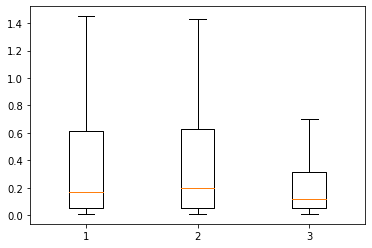

In [85]:
plt.boxplot([ps4_data['total_sales'], xone_data['total_sales'], ds_data['total_sales']], showfliers=False)

Here we see a comparison of the data between the PS3, Xbox One, and 3DS for the year 2016. **The distribution of total sales for each game between the PS4 and Xbox One are quite similar.** The PS4 however has significantly more outliers, some with much higher total sales than the outliers from the Xbox One console. The 3DS has outliers with even higher total sales than the PS4 - however, as we can see clearly from the second graph, the interquartile range of the 3DS is significantly smaller than the other consoles, and the median is the lowest of the three. The whiskers extend similarly for both the PS4 and Xbox One, and the IQRs and median are roughly the same. Looking at the distributions, the Xbox One doesn't seem like a bad choice as a platform to release a game on either!

## User reviews in regards to the PS4

Here we'll see if there is a correlation between user reviews and total sales for the PS4.

,user_score,total_sales
user_score,1.000000,-0.044788
total_sales,-0.044788,1.000000


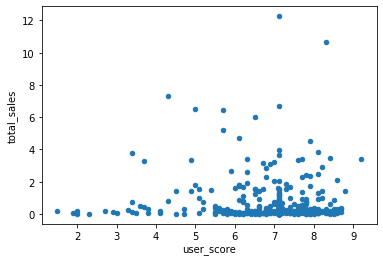

In [90]:
ps4_data.plot(x = 'user_score', y='total_sales', kind='scatter')

ps4_data[['user_score','total_sales']].corr()

Contrary to what people may think, based on our correlation coefficient it's safe to say that there isn't a correlation between user ratings and total sales. The highest selling game was rated close to a 7!

## Comparing sales of games across different platforms

In [10]:
#find games on the top 3 platforms
recent_subset = recent_data.query('platform == "PS4" | platform == "XOne" | platform == "3DS"')

'''
we need to figure out the steps necessary to find games that are sold on multiple platforms.
1. iterate through the names in the subset
2. create a hashmap, where the key is the name of the game, and the value is incremented each time we see the name
3. filter our subset based on values > 1 in our hashmap

all of this can be done with methods defined in the python/pandas libraries.
'''

# step 1 and 2
name_counts = recent_subset.name.value_counts()

#step 3
dupes = recent_subset[recent_subset['name'].isin(name_counts.index[name_counts.gt(1)])]

#now we sort, to make sure it works
dupes = dupes.sort_values('name')

dupes.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12863,7 Days to Die,XOne,2016,Action,0.03,0.02,0.00,0.00,35.0,5.2,M,0.05
9197,7 Days to Die,PS4,2016,Action,0.04,0.08,0.00,0.02,45.0,5.9,M,0.12
14940,Agatha Christie's The ABC Murders,PS4,2016,Adventure,0.01,0.01,0.00,0.00,67.0,6.2,T,0.02
16322,Agatha Christie's The ABC Murders,XOne,2016,Adventure,0.01,0.00,0.00,0.00,66.0,7.5,E,0.01
11243,Assassin's Creed Chronicles,PS4,2016,Action,0.01,0.05,0.01,0.01,NaN,6.1,T,0.07


In [11]:
#by using this, we can see most games are cross console between the PS4 and Xbox One. We'll compare these two.
dupes.groupby('platform').count()

ps4_x1 = dupes[(dupes['platform']=='PS4') | (dupes['platform']=='XOne')]
ps4_x1.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
12863,7 Days to Die,XOne,2016,Action,0.03,0.02,0.00,0.00,35.0,5.2,M,0.05
9197,7 Days to Die,PS4,2016,Action,0.04,0.08,0.00,0.02,45.0,5.9,M,0.12
14940,Agatha Christie's The ABC Murders,PS4,2016,Adventure,0.01,0.01,0.00,0.00,67.0,6.2,T,0.02
16322,Agatha Christie's The ABC Murders,XOne,2016,Adventure,0.01,0.00,0.00,0.00,66.0,7.5,E,0.01
11243,Assassin's Creed Chronicles,PS4,2016,Action,0.01,0.05,0.01,0.01,NaN,6.1,T,0.07


In [12]:
dupe_sales = ps4_x1.pivot_table(index='name',columns='platform', values = 'total_sales')

dupe_sales.head()


platform,PS4,XOne
name,,
7 Days to Die,0.12,0.05
Agatha Christie's The ABC Murders,0.02,0.01
Assassin's Creed Chronicles,0.07,0.01
Assassin's Creed The Ezio Collection,0.17,0.07
Assetto Corsa,0.05,0.01


here we can see the differences between game sales across the PS4 and Xbox One. 

let's average this out and see if there are differences between the sales of games between the two platforms.

In [139]:
dupe_sales['difference'] = dupe_sales['PS4'] - dupe_sales['XOne']

mean = dupe_sales['difference'].mean()
median = dupe_sales['difference'].median()

print('The mean difference between the sales on the PS4 and the Xbox One is:', mean, "\nThe median difference between the sales on the PS4 and the Xbox is:", median)

The mean difference between the sales on the PS4 and the Xbox One is: 0.27250000000000013 
The median difference between the sales on the PS4 and the Xbox is: 0.07499999999999998


cross platform games between the PS4 and the Xbox One are slightly different, with the **games sold on the PS4 averaging an approximate $272,500 more in total sales than the Xbox One.**

This data seems to reinforce our decision in choosing the PS4 as our platform of choice!

## Determining the most profitable genre of game

In [145]:
genre_data = recent_data.groupby('genre')
genre_data.agg({'total_sales':'sum'}).sort_values('total_sales',ascending=False)

,total_sales
genre,
Shooter,33.20
Action,27.04
Sports,20.47
Role-Playing,16.78
Fighting,3.93
Adventure,3.45
Platform,2.79
Racing,2.51
Misc,2.46


Looking at this chart, **shooters, action games, sports games, and RPGs** seem to the the best genre to make a game for. Let's take a look at the distribution of total sales by genre to see if our preliminary findings are correct.

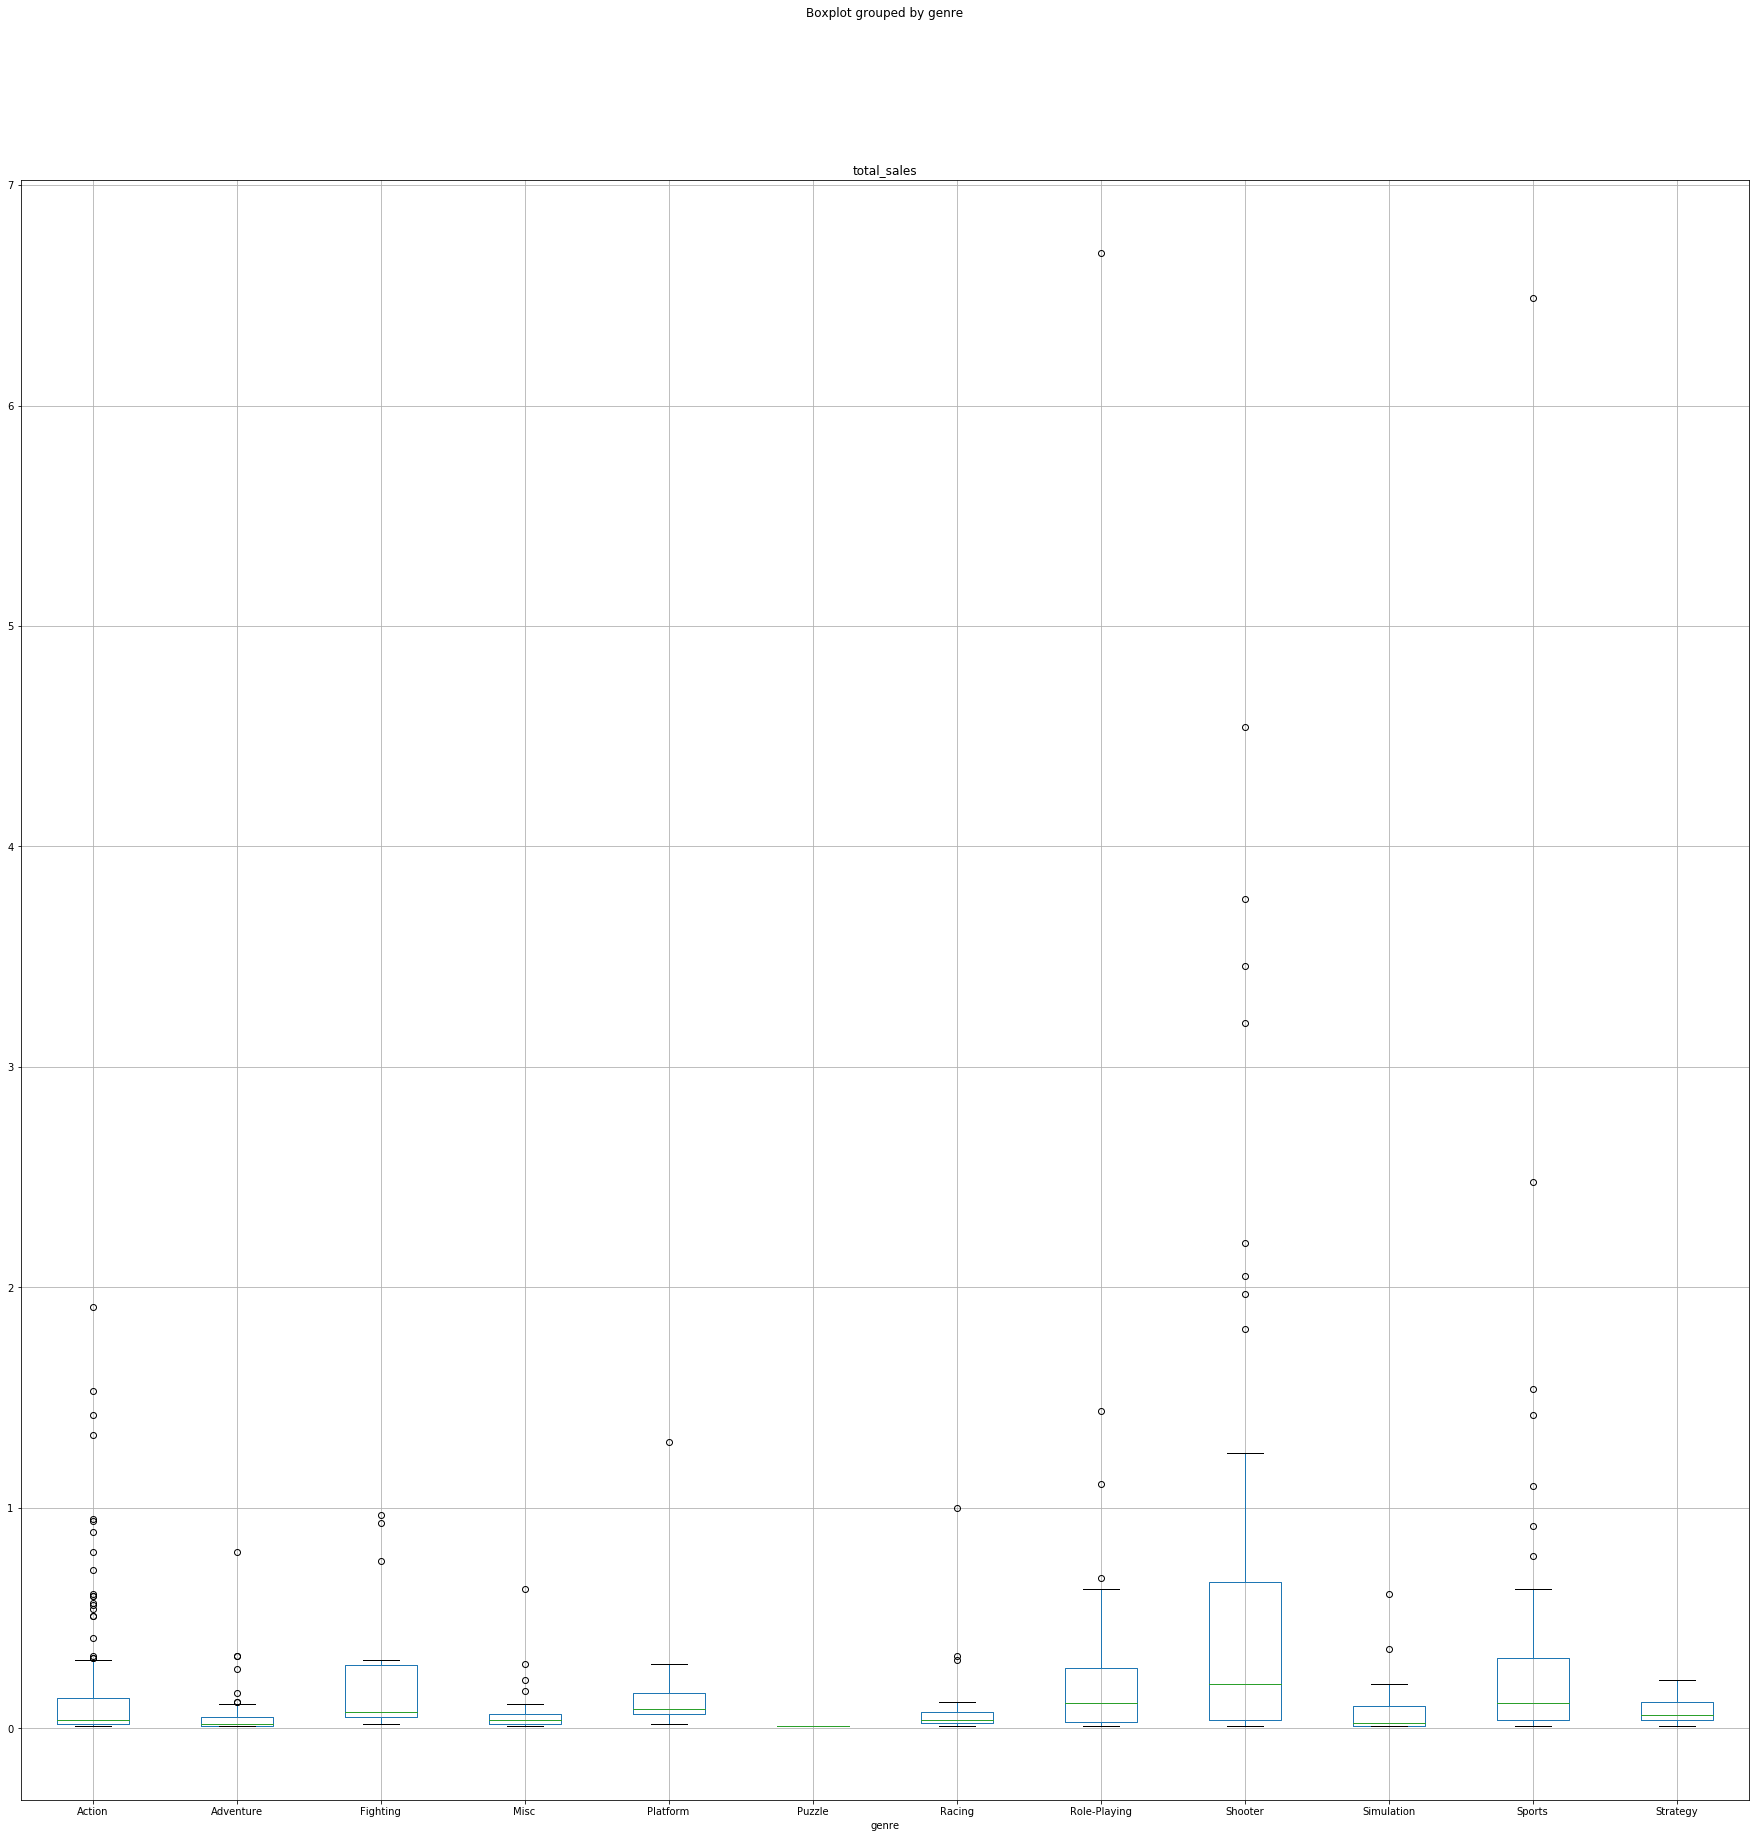

In [147]:
recent_data[['genre','total_sales']].boxplot(by='genre', column='total_sales', figsize = (30,30))

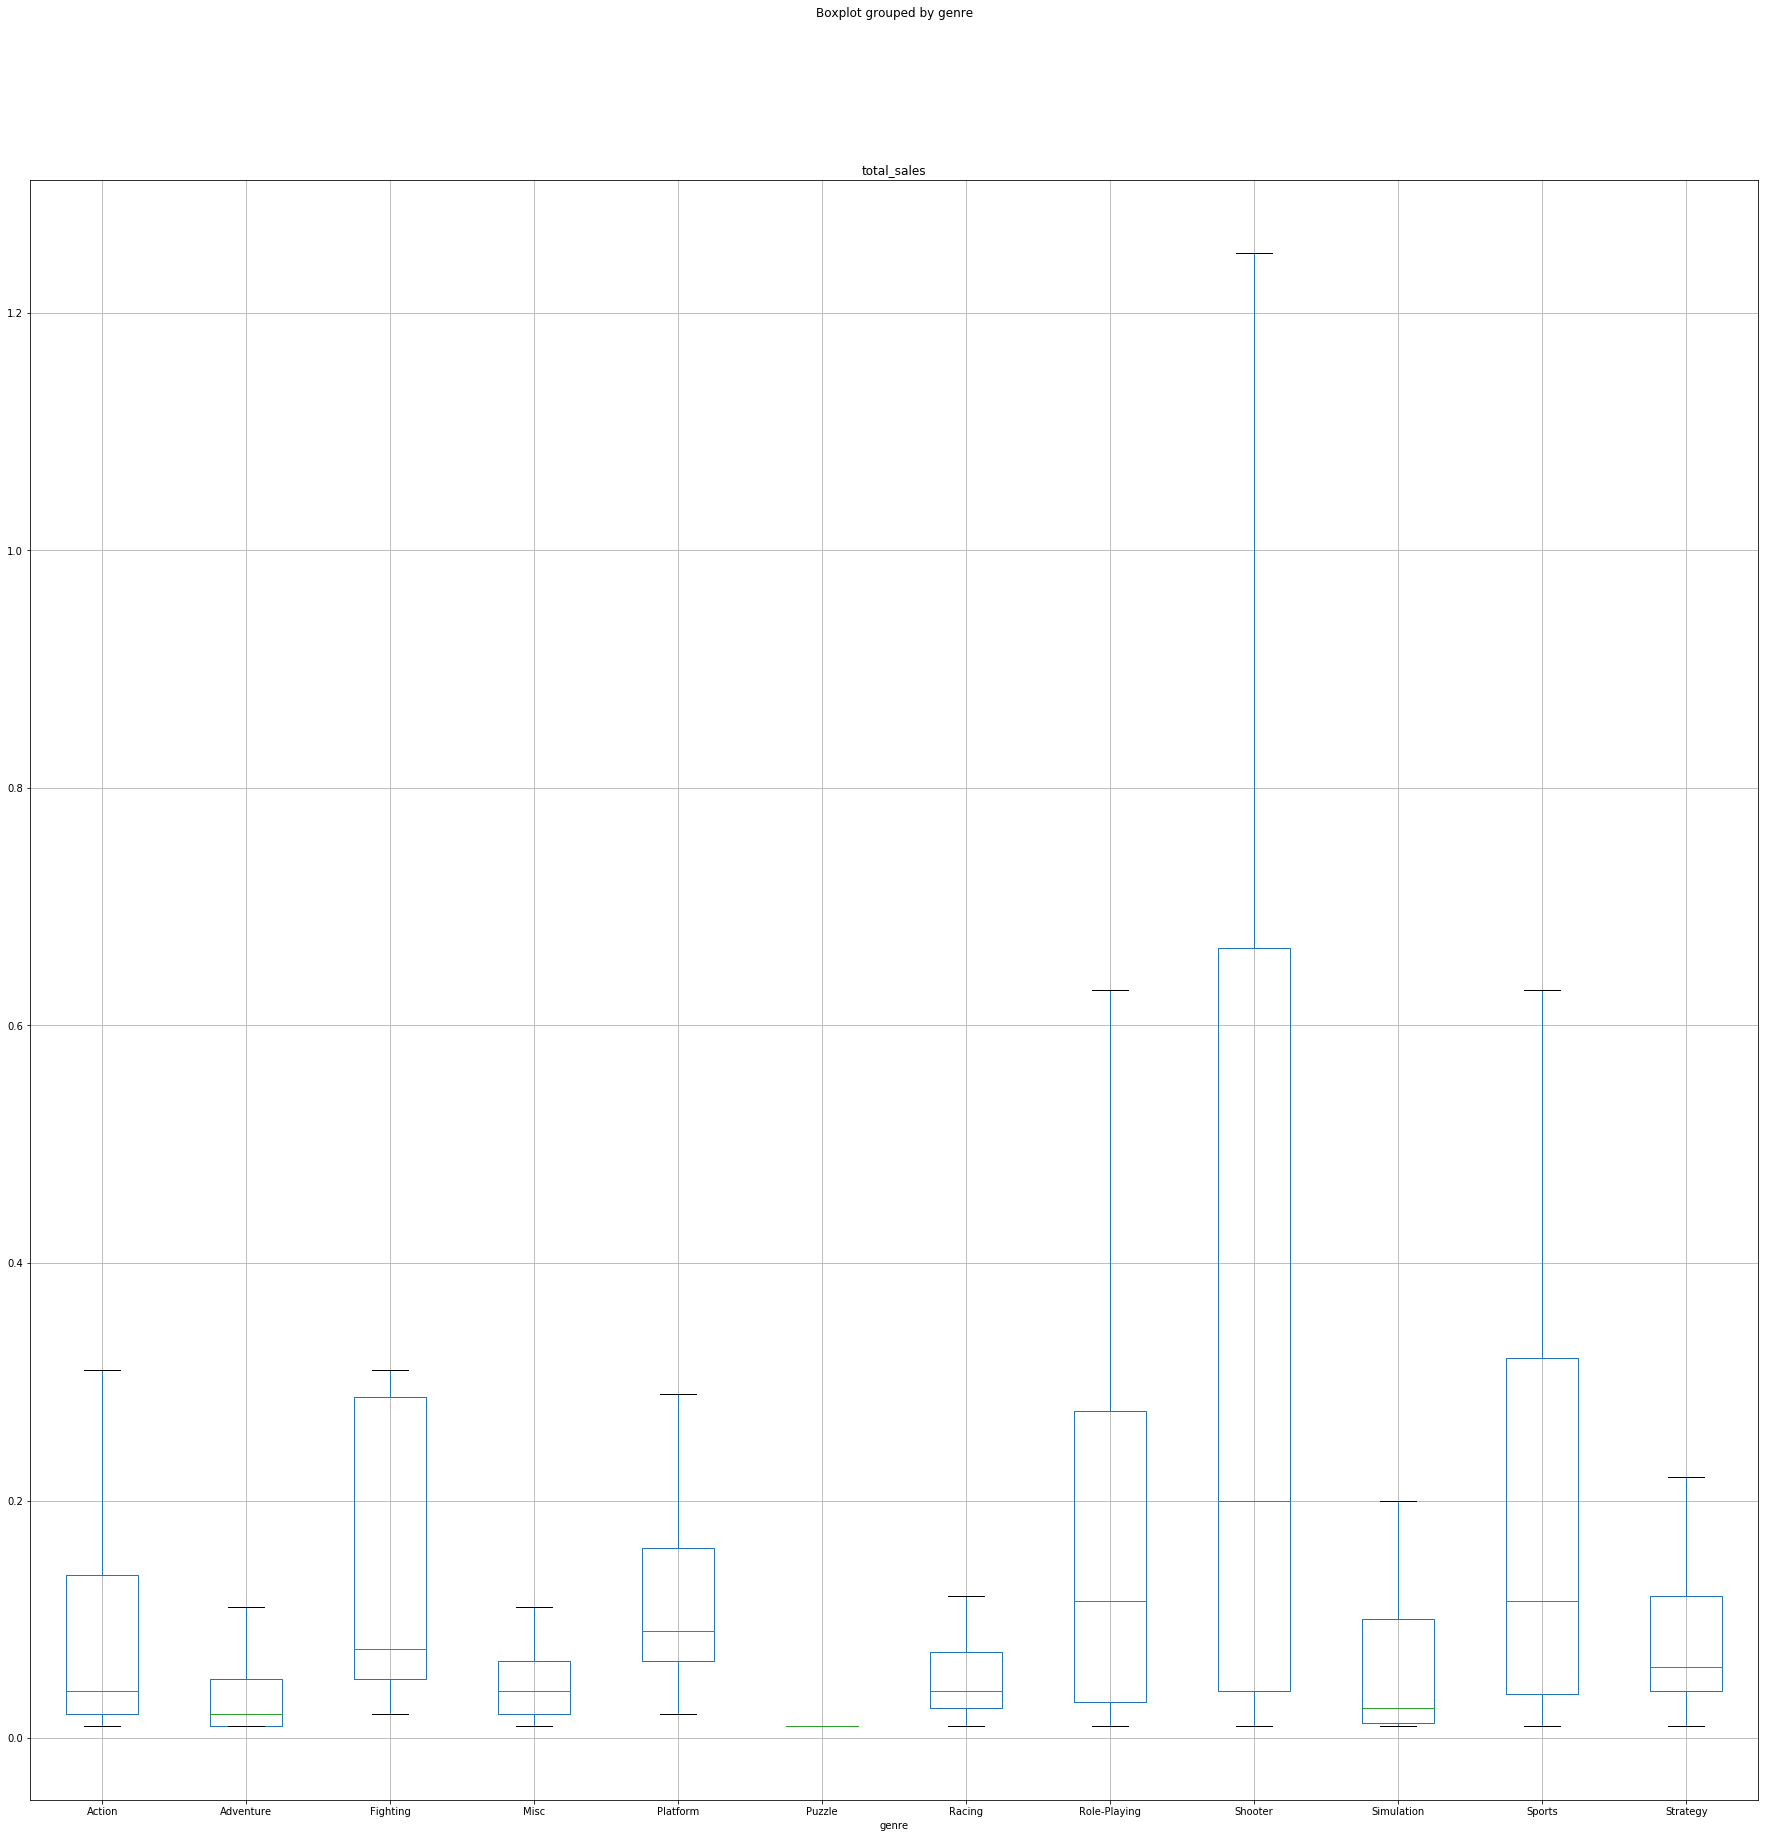

In [148]:
recent_data[['genre','total_sales']].boxplot(by='genre', column='total_sales', figsize = (30,30),showfliers=False)

We can confirm our findings, that Shooters, Sports games, Action games, and RPGs are highly profitable. Although the total profits are lower, fighting games also have an equatable distribution!
Looking at the boxplots, the low fence for all genres seem to be roughly the same - close to the 0 mark. In other words, there's no such thing as failsafe genre! The IRQs across the different genres are roughly similar as well, and all medians fall within the range of 0-200,000 dollars USD. Shooters have the highest median at around 200,000 dollars USD in sales, have the largest IQR among all the game genres, and highest fence among all the game genres. However, the highest outliers lie in the RPG and Sports genres.

It's hard to generalize information among the top genres, as the distributions are very different from each other, save for the RPG and Sports genres. However, bottom genres have many commonalities - small IQRs, few outliers(if any), and similar medians.

# Step 4: Create a user profile for each region

## By platform

In [195]:
# sum total sales for each platform, in descending order
top_platforms = recent_data.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales',ascending=False).reset_index()

#retrieve top 5 platforms
top_5_list = top_platforms['platform'][0:5].to_list()

#filter all games on the top 5 platforms
top_5_platforms = recent_data.query('platform in @top_5_list')

top_5_platforms_grouped = top_5_platforms.groupby('platform').agg({'na_sales':'sum','eu_sales':'sum','jp_sales':'sum','total_sales':'sum'})

top_5_platforms_grouped

,na_sales,eu_sales,jp_sales,total_sales
platform,,,,
3DS,4.14,2.33,8.03,14.50
PC,1.36,3.53,0.00,4.89
PS4,21.49,31.78,5.74,59.01
WiiU,2.10,1.48,0.67,4.25
XOne,14.27,9.63,0.01,23.91


looking at our data, we can see that game sales for each platform differ for each region.
* **JP** has the highest sales on **3DS games**
* **EU** has the highest sales on **PC games and PS4 games**
* **NA** has the highest sales on **WiiU games and Xbox One games**

## By genre

In [197]:
# sum total sales for each genre, in descending order
top_genres = recent_data.groupby('genre').agg({'total_sales':'sum'}).sort_values('total_sales',ascending=False).reset_index()

#retrieve top 5 genres
top_5_genres_list = top_genres['genre'][0:5].to_list()

#filter all games on the top 5 genres
top_5_genres = recent_data.query('genre in @top_5_genres_list')

top_5_genres_grouped = top_5_genres.groupby('genre').agg({'na_sales':'sum','eu_sales':'sum','jp_sales':'sum','total_sales':'sum'})

top_5_genres_grouped 

,na_sales,eu_sales,jp_sales,total_sales
genre,,,,
Action,9.29,10.68,7.07,27.04
Fighting,1.84,1.34,0.75,3.93
Role-Playing,5.89,4.28,6.61,16.78
Shooter,16.24,15.90,1.06,33.20
Sports,7.54,12.01,0.92,20.47


looking at our data, we can see that game sales for each genre differ for each region.
* **JP** has the highest sales on **RPGs**
* **EU** has the highest sales on **Action games and Sports games**
* **NA** has the highest sales on **Fighting games and Shooter games**

## By ESRB rating

In [199]:
esrb_data = recent_data.groupby('rating').agg({'na_sales':'sum','eu_sales':'sum','jp_sales':'sum','total_sales':'sum'})
esrb_data

,na_sales,eu_sales,jp_sales,total_sales
rating,,,,
E,16.50,21.08,15.39,52.97
E10+,3.81,3.81,0.45,8.07
M,15.67,16.54,1.20,33.41
T,8.95,9.79,2.27,21.01


looking at our data, we can see that game sales for each esrb rating differ for each region.
* **E** rated games sell relatively evenly between different regions.
* **E10+** rated games sell better in NA and EU compared to JP.
* **M** rated games sell poorly in JP.
* **T** rated games sell better in NA and EU.

# Step 5: Test the following hypotheses

## Hypothesis 1

Our first null hypothesis will be that average user ratings of the Xbox One and PC platforms do not differ. The alternative states that average user ratings of the Xbox One and PC platforms differ.

In [202]:
#set alpha
alpha = 0.05

#calculate result
results = st.ttest_ind(ps4_data['user_score'], xone_data['user_score'])
print('p-value:', results.pvalue)

#check our hypothesis
if(results.pvalue<alpha):
    print('We reject the null hypothesis')
else:
    print('We can\'t reject the null hypothesis')

p-value: 0.0432994765139477
We reject the null hypothesis


Based on our research, **there is statistically significant evidence that average user ratings of the Xbox One and PC platforms differ.**

## Hypothesis 2

Our second null hypothesis will be that the average user ratings for the Action and Sports genres do not differ. The alternative hypothesis states that the average user ratings for the Action and Sports genres are different.

In [203]:
action = recent_data.query('genre == "Action"')['user_score']
sports = recent_data.query('genre == "Sports"')['user_score']

#set alpha
alpha = 0.05

#calculate result
results = st.ttest_ind(action, sports)
print('p-value:', results.pvalue)

#check our hypothesis
if(results.pvalue<alpha):
    print('We reject the null hypothesis')
else:
    print('We can\'t reject the null hypothesis')

p-value: 5.602970965139628e-07
We reject the null hypothesis


Based on our research, **there is statistically significant evidence that average user ratings for the Action and Sports genres are different.**


# Step 6: Our Conclusion

Based on the data that we collected and analyzed, we determined that there are many different factors that contribute to the success of a game, and that the popularity of a game developed will vary drastically based on many different variables including the genre, console, and and country the game is released in. Even ESRB rating has a potential impact upon the popularity of a game between different countries! 

Although there may be other factors that contribute to the success of a game, at the very least we can utilize our data to increase the potential success of our game. Additionally, as long as a game is released within one of the top genres, the probability of greater profits increases; according to the distribution in our boxplots, there are many outliers with a huge variance in profits in these top genres.